<a href="https://colab.research.google.com/github/shahargonda/ProductReviewAnalysis/blob/main/cosmetic_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

uses Google Drive space

In [1]:
import re
import itertools 
import random
import time
import os
# basic data handling libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

! pip install langdetect 
from langdetect import detect

import torch

!pip install datasets transformers[sentencepiece]
! pip install sentence_transformers
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

import nltk
from nltk import tokenize
nltk.download('punkt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 30.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=09050260004792589d4e8616be096cd02ccdde01d60dc5512edf8f9f8afaf8f6
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 9.6 MB/s 
     |████████████████████████████████| 5.3 MB 44.3 MB/s 
     |████████████████████████████████| 163 kB 58.1 MB/s 
     |████████████████████████████████| 212 kB 55.6 MB/s 
     |████████████████████████████████| 115 kB 53.8 MB/s 
     |████████████████████████████████| 127 kB 64.5 MB/s 
     |████████████████████████████████| 7.6 MB 27.9 MB/s 
     |████████████████████████████████| 1.3

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# toggle: 
#initial_directory= r'/content/drive/MyDrive/Shahar/technical/menow/'
initial_directory= r'/content/drive/MyDrive/Me_Now_nlp_project/'

import glob

for name in glob.glob(initial_directory+'*'):
    print(name)

/content/drive/MyDrive/Me_Now_nlp_project/data
/content/drive/MyDrive/Me_Now_nlp_project/code
/content/drive/MyDrive/Me_Now_nlp_project/analysis


In [4]:
import glob
data_path=initial_directory+'data/'
analysis_path=initial_directory+'analysis/'
# dir
for name in glob.glob(data_path+'*'):
  print(name)
# different destinations
body_products = [name for name in glob.glob(data_path+'*body*')]
facial_products = [name for name in glob.glob(data_path+'*facial*')]
eye_products = [name for name in glob.glob(data_path+'*eye*')]

/content/drive/MyDrive/Me_Now_nlp_project/data/body_muds.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/body_cleansers.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/body_moisturizers.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/eye_creams.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/eye_gels.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/facial_cleansing_bars.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/BB_facial_creams.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/body_shower_set.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/eye_balms.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/eye_masks.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/duplicated.csv
/content/drive/MyDrive/Me_Now_nlp_project/data/desktop.ini


In [5]:
# change this line when analysing different products 
currently_analyzing= '_body_cleansers'
filenames= body_products[1]

In [6]:
filenames

'/content/drive/MyDrive/Me_Now_nlp_project/data/body_cleansers.csv'

In [7]:
def create_df_from_files(filenames):
    print ('we will be analyzing the following files:', filenames)
    if not isinstance(filenames, list):
      filenames=[filenames]
    df=[]
    for filename in filenames:
      current_df= pd.read_csv (filename)
      if len(df)==0:
        df=current_df
      else:
        df=pd.concat((df,current_df))
      # make sure df is growing:
      print('dataframe length:', df.shape[0])  
    return df  

#df= create_df_from_files(filenames)

In [8]:
def print_basic_info(df):
  print('shape of df:', df.shape)

  print('df columns:', df.columns)
  
  print('here is an example of the content:')
  print(df.head())

# print_basic_info(df)

In [9]:
# getting rid of duplicates

def drop_duplicates_and_report(df, dir_path=analysis_path):
  n_lines_before=df.shape[0]
  
  # # checking that they are really duplicates- done seperately on excel
  # df[df.duplicated(keep=False)].to_csv(dir_path+'duplicated.csv',sep=';')

  df.drop_duplicates(subset=None, keep='first', inplace=True)
  print(f'Dropped {n_lines_before-df.shape[0]} duplicated lines')
  return df

# df= drop_duplicates_and_report(df)

In [10]:
def drop_missing_and_concatenate_title_and_review(df):
  # look at the textual columns
  df.info()
  #there are empty titles and empty reviews!

  # checking if all empty titles also don't have a review
  print ('\n These are the titles where the review body is empty \n')
  print (df[df['review_title'].isna()]['review_body'])
  #nope
  
  # checking if all empty reviews also have empty titles or not
  print( '\n These is the review body where the title field is empty: \n')
  print(df[df['review_body'].isna()]['review_title'])
  #nope
  
  # omitting where they are both null- only one review like this
  print('omitting results where they are both empty:')
  n_lines_before= df.shape[0]
  df.dropna(axis=0, how='all', thresh=None, subset=['review_title','review_body'], inplace=True)
  print (f'{n_lines_before-df.shape[0]} lines have been omitted')
  #checking:
  df[df['review_title'].isna() & df['review_body'].isna()]
  #now an empty dataframe
  

  # replacing nulls in review title and body with ''
  df.fillna({'review_body':'', 'review_title':''}, inplace=True)
  ## checking:
  #print(df[df['review_body'].isna()]['review_title'])
  #print(df[df['review_title'].isna()]['review_body'])

  # concatenating review title and body 
  
  print('\n concatenating review title and body \n')
  df['review'] = df[['review_title', 'review_body']].agg(' '.join, axis=1)
  #df['review'].head()
 
  # # optional - i opt out of 
  # 
  # # omitting the original columns
  # del df['review_title']
  # del df['review_body']
  # 
 
  return df


# df=drop_missing_and_concatenate_title_and_review(df)

In [11]:
def filter_for_enlish_reviews(df):
  num_reviews_before_filtering= df.shape[0]

  # detect all english documents

  def detect2(input):
    if bool(re.match('^(?=.*[a-zA-Z])', input)):
      #return detect(input)
      # toggle with block: 
      if len(input) > 30:
        try:                                                          
          lang=detect(input)                                      
        except:                                                                                                    
          print("This text throws error:", input)  
          lang= 'id'
        return lang
      else:
        return 'id'
    else: 
      return 'id'  
  print ('\n Screening for English reviews only \n')
  df['english']=df.review.apply(detect2).eq('en')
  # percent of english reviews
  print('percent of english reviews', df['english'].sum()/df.shape[0])

  # drop all nonenglish reviews
  df= df[df['english']]

  df.drop('english', inplace=True, axis=1)
  print('reviews remaining', df.shape[0])
  # reviews remaining 
  print(f'we got ride of {(1-df.shape[0]/num_reviews_before_filtering):%} of non-english reviews')

  return df
# df= filter_for_enlish_reviews(df) 

In [12]:
def lowercase_review_field(df):
  # all small caps now:
  df['review2']= df.review.astype(str).str.lower()
  df['review2']

  df.drop(columns='review', inplace=True)
  df.rename(columns = {'review2':'review'}, inplace = True)

  return df
#df= lowercase_review_field(df)

In [13]:
def save_checkpoint_preprocessed_df(df, currently_analyzing=currently_analyzing, lib_path=analysis_path):
  # reseting index- this will give a new stratline for future reference
  df.reset_index(drop=True, inplace=True)
  # saving the result in order to not do all of this again
  df.to_csv(lib_path+'english_reviews'+currently_analyzing+'.csv', sep=';')

#save_checkpoint_preprocessed_df(df)

In [14]:
def load_and_preprocess(data_path, filenames, currently_analyzing, analysis_path):
  df= create_df_from_files(filenames)
  print_basic_info(df)
  df= drop_duplicates_and_report(df)
  df=drop_missing_and_concatenate_title_and_review(df)
  df= filter_for_enlish_reviews(df)
  df= lowercase_review_field(df)
  save_checkpoint_preprocessed_df(df)
  return df

In [15]:
#currently_analyzing= '_body_cleansers'
#filenames= body_products[3]

def make_or_load_df(currently_analyzing, analysis_path):
  # create_checkpoint_search_term
  src= analysis_path+'english_reviews'+currently_analyzing+'.csv'

  if glob.glob(src) == []:
    # loading raw data, preprocessing
    print ("Data hasn't been encountered before- load and preprocess")
    df= load_and_preprocess(data_path, filenames, currently_analyzing, analysis_path)
  else:
    print ("Load preprocessed df from checkpoint")
    df=pd.read_csv(src, sep=';')
  return df  
  #df= load_and_preprocess(data_path, filenames, currently_analyzing, analysis_path)

In [16]:
%%script false --no-raise-error
# main loading call
df= make_or_load_df(currently_analyzing, analysis_path)

keyword analysis

In [17]:
#path to the directory where the analysis data is:
analysis_path = initial_directory+'analysis/'
keywords_file_name= 'NLP_keywords.csv'

def open_keywords_df(analysis_path, keywords_file_name):
  keywords_df = pd.read_csv(analysis_path+keywords_file_name)
  return keywords_df

keywords_df= open_keywords_df(analysis_path, keywords_file_name)

In [18]:
def keyword_analysis(df, keywords_df):
  keywords_count_df, condition_count_df, skin_conditions= create_keyword_and_condition_df(df, keywords_df)
  condition_count_df= analyze_keyword_and_condition_df( keywords_count_df, condition_count_df, skin_conditions)
  return keywords_count_df, condition_count_df

In [19]:
def create_keyword_and_condition_df(df, keywords_df):
  keywords_count_df =  count_keyword_appearances(df, keywords_df)
  condition_count_df, skin_conditions= infer_conditions_from_keywords_appearances(df, keywords_count_df, keywords_df)  
  return keywords_count_df, condition_count_df, skin_conditions

def analyze_keyword_and_condition_df( keywords_count_df, condition_count_df, skin_conditions, save_no_keywords=False):  
  report_no_keywords(keywords_count_df, save_no_keywords, analysis_path=analysis_path, currently_analyzing=currently_analyzing)
  countlist, sorted_condition_list = sort_condition_count(condition_count_df, skin_conditions)
  condition_count_df= resort_columns_condition_count_df(condition_count_df, sorted_condition_list)
  print_rating_histogram_per_condition(condition_count_df, keywords_df, countlist)
  report_co_occurance_of_conditions (condition_count_df, sorted_condition_list)
  return condition_count_df

In [20]:
def count_keyword_appearances(df, keywords_df):
  
  def check_review_for_keyword(review, keyword):
      return int(re.search(keyword, review) is not  None) if isinstance(review, str) else int(0)

  #keywords2idxs= {keyword:i for i,keyword in enumerate(keywords_df['Keyword'])}
  #idxs2keywords= {value:key for key,value in keywords2idxs.items()}

  # list which review contains which keyword
  keyword_list=pd.unique(keywords_df['Keyword'])

  print('creating keyword_appearance table')
  keywords_count_df= df[['product_name', 'rating', 'review']]
  for keyword in keyword_list:
      keywords_count_df[keyword]= df['review'].apply(lambda x: check_review_for_keyword(x, keyword))
      #print(f"{keyword:25} {keywords_count_df[keyword].sum():4}")
  return keywords_count_df

In [21]:
def infer_conditions_from_keywords_appearances(df, keywords_count_df, keywords_df):
  skin_conditions= pd.unique(keywords_df['Condition'])
  # adding a column in keywords_count_df for all keywords of the same condition 
  condition_count_df= df[['product_name', 'rating', 'review']]
  for i, condition in enumerate(skin_conditions):
    keywords= list(keywords_df[keywords_df['Condition']==condition]['Keyword'])
    
    # creating a condition_count dataframe that aggragates keywords for a total condition count 
    condition_count_df[condition]= (keywords_count_df[keywords]==1).astype(bool).sum(axis=1)
  return condition_count_df, skin_conditions  
  

In [22]:
def report_no_keywords(keywords_count_df,save_no_keywords=False, analysis_path=analysis_path, currently_analyzing=currently_analyzing ):
  # let's see how many of these reviews do not contain the keywords:
  keyword_list=pd.unique(keywords_df['Keyword'])
  no_keywords_df=keywords_count_df[(keywords_count_df[keyword_list]==0).all(axis=1)]
  n_no_keywords= no_keywords_df.shape[0]
  print('number of reviews not matching any of our interest keywords:', n_no_keywords)
  # the percent of these from all reviews
  print('percent irrelevant reviews', n_no_keywords/keywords_count_df.shape[0])

  # MOST reviewes do not contain the keywords

  if save_no_keywords:
    # save a dataframe of reviews with none of the keywords for inspection
    no_keywords_df[['product_name','review','rating']].to_csv(analysis_path+currently_analyzing+'no_keywords.csv', sep=';')
  
  # let's look at one random review with no keyword
  rando= random.randint(0, n_no_keywords)
  print("this is a sample of a review that doesn't contain any of the keywords:")
  print(no_keywords_df.reset_index()['review'][rando])


In [23]:
def sort_condition_count(condition_count_df, skin_conditions):
  # sort conditions by frequency count
  countlist=[]
  for condition in skin_conditions:
    condition_count= (condition_count_df[condition]>0).sum()
    #print(condition_count)
    countlist.append((condition, condition_count))
    #print (f'[{condition_count:5}] {condition}:{keywords}') 

  countlist= sorted(countlist, key=lambda x:x[1], reverse=True)  
  sorted_condition_list=[condition for condition,condition_count in countlist] 
  
  # print counts and keywords for condition 
  for condition, count in countlist:
    keywords= list(keywords_df[keywords_df['Condition']==condition]['Keyword'])
    #condition_df= counts_df[(counts_df[keywords]==1).any(axis=1)].reset_index()
    #condition_count=condition_df.shape[0]
    print (f'[{count:5}] {condition}:{keywords}')
  return countlist, sorted_condition_list


In [24]:
def resort_columns_condition_count_df(condition_count_df, sorted_condition_list):
  rest_of_columns= [col for col in condition_count_df.columns if col not in sorted_condition_list]
  condition_count_df = condition_count_df.reindex(columns=rest_of_columns+sorted_condition_list) 
  return condition_count_df

In [25]:
%%script false --no-raise-error
#main keyword analysis call 
keywords_count_df, condition_count_df= keyword_analysis(df, keywords_df)

In [26]:
def print_rating_histogram_per_condition(condition_count_df, keywords_df, countlist):
  # inspect the distribution of ratings when a skin condition is at hand

  fig, axes= plt.subplots(3,4,figsize=(12,12),sharey='all')
  fig.suptitle('distribution of ratings for reviews mentioning skin condition', y=0.93)
  axes_list = [item for sublist in axes for item in sublist] 
  for condition, count in countlist:
    keywords= list(keywords_df[keywords_df['Condition']==condition]['Keyword'])
    condition_df= condition_count_df[condition_count_df[condition]>0]
    #print (f'[{condition_count:5}] {condition}:{keywords}')
    
    ax = axes_list.pop(0)
    #print(condition_df.groupby('product_name').rating.agg('mean'))
    condition_df.groupby('product_name').rating.agg('mean').hist(ax=ax, bins=(5-1)*10)
    ax.set_title(condition+f', tot={count}')
    ax.set_xlabel('mean rating')
    ax.set_ylabel('count')
    ax.tick_params(
          which='both',
          bottom='off',
          left='off',
          right='off',
          top='off'
    )
    ax.set_xlim((1, 5))
    ax.grid(linewidth=0.25)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
  for ax in axes_list:
      ax.remove()  
  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  plt.show()


In [27]:
def report_co_occurance_of_conditions(condition_count_df, sorted_condition_list):
  two_or_more_conditions = condition_count_df[sorted_condition_list][(condition_count_df[sorted_condition_list]>=1).sum(axis=1)>=2]

  plt.figure(figsize=(15,50)) # increase second number for longer graph
  with sns.axes_style("white"): 
    ax = sns.heatmap(two_or_more_conditions.sort_values(by=sorted_condition_list[::-1],ascending=False ), linewidth=0, cmap="YlGnBu")
    plt.title('What conditions do reviews mention together?')
    plt.show()

  # correlation matrix! 
  cormat = condition_count_df[sorted_condition_list].corr()
  mask = np.triu(np.ones_like(cormat, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(cormat, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.title('correlation between conditions in reviews')
  plt.show()

  #todo look at the combination acne%&pigmentation and read some revies to see if they are seperable

#report_co_occurance_of_conditions (condition_count_df, sorted_condition_list)

In [28]:
def get_reviews_by_cond_and_rating(condition_to_analyze, rating_list_to_analyze, verbose=False):
  if condition_to_analyze=='all_reviews':
    condition_mask= np.ones_like(condition_count_df['review'])
    #print(condition_mask.shape)
  else:
    condition_mask= condition_count_df[condition_to_analyze]>0  
  print(f'analyzing condition: {condition_to_analyze}, rating {rating_list_to_analyze}')
  rating_mask= condition_count_df['rating'].isin(rating_list_to_analyze)
  rating_condition_mask= np.logical_and(condition_mask, rating_mask)
  if verbose: 
    for review in keywords_count_df[rating_condition_mask]['review']:
      print(review)
      print ()
  print (f'number of sentences in this section : {keywords_count_df[rating_condition_mask].shape[0]}')  
  return rating_condition_mask


In [29]:
%%script false --no-raise-error
pipline_task= "sentiment-analysis"
tokenizer_kwargs= {'padding':True,'truncation':True,'max_length':512}

In [30]:
def sentiment_analysis(rating_condition_df, COLNAME='review', pipline_task="sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english', verbose=0, **kwargs):
  print ('preforming sentiment analysis')
  # sentiment analysis
  classifier = pipeline(pipline_task, model=model)
  #tokenizer_kwargs = tokenizer_kwargs
  sentiment_analysis_result=classifier(list(rating_condition_df[COLNAME]), **kwargs)
  sentiment_results= pd.DataFrame()
  sentiment_results['label']= pd.DataFrame([line['label'] for line in sentiment_analysis_result])
  sentiment_results['certainty']= pd.DataFrame([line['score'] for line in sentiment_analysis_result])
  
  if verbose>0:
  # we expect all of the results to be "negative sentiment". let's see:
    num_positive= sentiment_results.label.apply(lambda x: x=='POSITIVE').sum()
    num_negative= sentiment_results.label.apply(lambda x: x=='NEGATIVE').sum()
    print (f'# negative classification: {num_negative} \n# positive classification: {num_positive}') 
  if verbose>1:
    pass
  return sentiment_results


In [31]:
def print_section(rating_condition_df,sentiment_results, label, direction, sa_TH=0.9, verbose=False, dilution=1):
  print(f'{"*"*10} {label} , probability {direction} than {sa_TH} {"*"*10}')
  if direction=="<":
    error_idxs= np.logical_and(sentiment_results.label==label ,sentiment_results.certainty<=sa_TH).to_numpy().nonzero()[0]
  else: 
    error_idxs= np.logical_and(sentiment_results.label==label,sentiment_results.certainty>=sa_TH).to_numpy().nonzero()[0]
  error_reviews= rating_condition_df.loc[list(error_idxs)]['review']
  print (f'Number of reviews like this: {error_idxs.shape[0]} \n')
  if verbose:
    for i,review in enumerate(error_reviews):
      if (i+1)%dilution ==0 :
        print (review,'\n')
  return error_idxs      
    

def error_analysis_of_sentiment(rating_condition_df, sentiment_results, sa_TH=0.9):
  # POS, prob>TH
  print_section(rating_condition_df,sentiment_results, 'POSITIVE', ">", sa_TH=sa_TH, verbose=False)  
  # POS, prob<=TH
  print_section(rating_condition_df,sentiment_results, 'POSITIVE', "<", sa_TH=sa_TH, verbose=False)  
  # NEG, prob<=TH
  print_section(rating_condition_df,sentiment_results, 'NEGATIVE', "<", sa_TH=sa_TH, verbose=False)  
  # NEG, prob>TH
  sure_sentiment_pool_idxs= print_section(rating_condition_df,sentiment_results, 'NEGATIVE', ">", sa_TH=sa_TH, verbose=True)  
  return sure_sentiment_pool_idxs


In [32]:
# seperate each review into sentences and return a df with sentences and indices for refernce 
def return_sentence_df(reviews_df, original_indexes, original_df_indices, extra=True, extra_string=r'[.-;]'):
  list_of_sentences=[]
  list_of_indexes=[]
  list_of_orig_df_indexes=[]
  for i,review in enumerate(reviews_df):
    # utilize nltk seperator
    result= tokenize.sent_tokenize(review)
    # can stop here. but if not enough:
    if extra:
      # add another seperator because there were still sentences seperated by "." with no white space after
      # result = [re.split(r'[.-;]', sent) for sent in result]
      result = [re.split(extra_string, sent) for sent in result]
      # filter empty strings as they are not sentences
      result= [[sent for sent in sent_list if bool(re.match('^(?=.*[a-zA-Z])', sent))] for sent_list in result] 
      # flattening result to get a list of sentences
      result= list(itertools.chain.from_iterable(result))
    list_of_indexes.extend([original_indexes[i]]*len(result))
    list_of_orig_df_indexes.extend([original_df_indices[i]]*len(result))
    list_of_sentences.extend(result)
  indexes_and_sentences_df= pd.DataFrame()
  indexes_and_sentences_df['indexes']=pd.Series(list_of_indexes)
  indexes_and_sentences_df['original_df_indices']=list_of_orig_df_indexes
  indexes_and_sentences_df['sentences']=pd.Series(list_of_sentences) 

  return indexes_and_sentences_df

In [33]:
%%script false --no-raise-error
s_transformer_string= 'paraphrase-albert-small-v2'
#s_transformer_string= 'all-MiniLM-L12-v2'

condition_to_analyze='dry skin'
bad_rating_list=[1]
pool_rating_list=[2,3,4,5]
TH=0.9

In [34]:
def get_reviews_by_cond_and_rating(condition_count_df, condition_to_analyze, rating_list_to_analyze, verbose=False):
  if condition_to_analyze=='all_reviews':
    condition_mask= np.ones_like(condition_count_df['review'])
    print(condition_mask.shape)
  else:
    condition_mask= condition_count_df[condition_to_analyze]>0  
  print(f'analyzing condition: {condition_to_analyze}, rating {rating_list_to_analyze}')
  rating_mask= condition_count_df['rating'].isin(rating_list_to_analyze)
  rating_condition_mask= np.logical_and(condition_mask, rating_mask)
  if verbose: 
    ### NOTICE this has been changed - replace keyword_count_df with condition_count_df
    for review in condition_count_df[rating_condition_mask]['review']:
      print(review)
      print ()
  print (f'number of sentences in this section : {condition_count_df[rating_condition_mask].shape[0]}')  
  return rating_condition_mask

def get_condition_string(kind_of_info, transformer, condition, rating):
  rating_str="".join((str(i)for i in rating))
  src= kind_of_info+transformer+condition_to_analyze+rating_str
  return src 


In [35]:
def return_keywords(keywords_df, condition_to_analyze ):
  # only use sentences that match the keyword within sentence 
  keywords= list(keywords_df[keywords_df['Condition']==condition_to_analyze]['Keyword'])
  #keywords
  return keywords

#keywords = return_keywords(keywords_df, condition_to_analyze)


# def check_for_keyword(review, keyword):
#     return int(re.search(keyword, review) is not  None) if isinstance(review, str) else int(0)

# func_at_least_one_word_from_keywords= lambda x: any([check_for_keyword(x, word) for word in keywords])

# def filter_quaries_to_keywords(corpus_of_queries, keywords):
#   return corpus_of_queries[corpus_of_queries['sentences'].apply(func_at_least_one_word_from_keywords)]

def filter_queries_to_condition(corpus_of_queries, keywords_df, condition_to_analyze):
  keywords= list(keywords_df[keywords_df['Condition']==condition_to_analyze]['Keyword'])
  def check_for_keyword(review, keyword):
    keyword=" "+keyword
    return int(re.search(keyword, review) is not  None) if isinstance(review, str) else int(0)
  func_at_least_one_word_from_keywords= lambda x: any([check_for_keyword(x, word) for word in keywords])
  return corpus_of_queries[corpus_of_queries['sentences'].apply(func_at_least_one_word_from_keywords)]

def prepare_queries(condition_count_df, keywords, condition_to_analyze, rating_list_to_analyze, sa_TH=0.9, filter_queries=True , **tokenizer_kwargs, ):
  rating_condition_mask= get_reviews_by_cond_and_rating(condition_count_df, condition_to_analyze, rating_list_to_analyze)
  orig_df_indices= np.where(rating_condition_mask)[0]
  rating_condition_df= condition_count_df[rating_condition_mask].reset_index()
  sentiment_results = sentiment_analysis(rating_condition_df, **tokenizer_kwargs)
  #print(sentiment_results.certainty)
  sure_sentiment_pool_idxs = error_analysis_of_sentiment(rating_condition_df, sentiment_results, sa_TH=sa_TH)
  orig_df_indices_after_analysis= orig_df_indices[sure_sentiment_pool_idxs]
  bad_reviews_indexes_and_sentences_df= return_sentence_df(rating_condition_df.review[sure_sentiment_pool_idxs],sure_sentiment_pool_idxs, orig_df_indices_after_analysis)
  if filter_queries:
    bad_reviews_indexes_and_sentences_df= filter_queries_to_condition(bad_reviews_indexes_and_sentences_df, keywords_df, condition_to_analyze)
  return bad_reviews_indexes_and_sentences_df

def cluster_embeddings(corpus_embeddings, min_community_size=3, cluster_TH=0.75):
  print("Start clustering")
  start_time = time.time()
  #Two parameters to tune:
  #min_cluster_size: Only consider cluster that have at least n elements
  #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
  clusters = util.community_detection(corpus_embeddings, min_community_size=min_community_size, threshold=cluster_TH)
  print("Clustering done after {:.2f} sec".format(time.time() - start_time))
  return clusters

def print_clusters(queries, clusters):
  for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", queries[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", queries[sentence_id])       

def extract_centers(queries, clusters, verbose=False):  
  #extract first sentence of every cluster:
  list_of_middles= [cluster[0] for cluster in clusters]
  #print(small_df)
  middle_cluster_sentences= [queries[i] for i in list_of_middles]
  if verbose:
    print(list_of_middles)
    print(middle_cluster_sentences)
  return middle_cluster_sentences  

def prepare_center_of_cluster_centences(model, queries, verbose=True):
  queries_encodings= model.encode(queries, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
  clusters = cluster_embeddings(queries_encodings, min_community_size=3, cluster_TH=cluster_TH)
  if verbose:
    print_clusters(queries, clusters)
  middle_cluster_sentences= extract_centers(queries, clusters, verbose=True)
  return middle_cluster_sentences
    
def prepare_answer_pool(condition_count_df, pool_rating_list):
  rating_condition_mask= get_reviews_by_cond_and_rating(condition_count_df, 'all_reviews', pool_rating_list)
  original_df_indices= np.where(rating_condition_mask)[0]
  rating_condition_df= condition_count_df[rating_condition_mask].reset_index()
  index_pool=np.array(range(rating_condition_df.shape[0]))
  pool_reviews_indexes_and_sentences_df= return_sentence_df(rating_condition_df.review[index_pool],index_pool, original_df_indices)
  return pool_reviews_indexes_and_sentences_df 

def get_encodings(model, filename_str, corpus):
  src=filename_str
  #src= analysis_path+condition_string+".csv"
  if glob.glob(src) == []:
    print("corpus hasn't been encoded before using this transformer")
    print('encoding corpus - this might take a while')
    encodings= model.encode(corpus, show_progress_bar=True)
    encodings_df= pd.DataFrame(encodings)
    print('saving result embeddings')
    encodings_df.to_csv(filename_str)
    # try me
    #encoding= embeddings_df   
    encodings= pd.read_csv(filename_str, index_col=False).values[:,1:]  
  else:
    print("loading encodings from file")
    print(glob.glob(src))
    encodings= pd.read_csv(filename_str, index_col=False).values[:,1:]  
  return encodings

def prepare_corpra(condition_count_df, condition_to_analyze, keywords):
  corpus_of_queries = prepare_queries(condition_count_df, keywords=keywords, condition_to_analyze=condition_to_analyze, rating_list_to_analyze=bad_rating_list, sa_TH=sa_TH, **tokenizer_kwargs)
  answer_pool = prepare_answer_pool(condition_count_df, pool_rating_list)
  return corpus_of_queries, answer_pool

def semantic_search():
  return

def spelled_out_transformers_application(condition_count_df, keywords, condition_to_analyze, s_transformer_string):
  model = SentenceTransformer(s_transformer_string)
  corpus_of_queries = prepare_queries(condition_count_df, keywords=keywords, condition_to_analyze=condition_to_analyze, rating_list_to_analyze=bad_rating_list, sa_TH=sa_TH, **tokenizer_kwargs)
  answer_pool = prepare_answer_pool(condition_count_df, pool_rating_list)
  manual_sentences= ['this does not moisturize at all', 'not as moisturizing as i hoped', "very bad for dry skin", "not recommended for dry skin", "dry skin got worse", "it dried my skin"]
  
  print('a few sentences from the queries:')
  print(corpus_of_queries.sentences.head())
  print('a few sentences from the answer pool:')
  print(answer_pool.sentences.head())

  center_of_clusters_embedding_string= analysis_path+"embeddings/"+get_condition_string('center_of_clusters', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  print('center_of_clusters_embedding_string:', center_of_clusters_embedding_string)
  center_of_clusters= prepare_center_of_cluster_centences(model, corpus_of_queries.reset_index().sentences)
  center_of_clusters_embeddings= get_encodings(model, center_of_clusters_embedding_string, center_of_clusters)

  queries_embeding_string= analysis_path+"embeddings/"+get_condition_string('queries_embeddings', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  # drop duplicate sentences
  corpus_of_queries= corpus_of_queries.drop_duplicates(subset='sentences').reset_index().sentences
  print('queries_embeding_string:', queries_embeding_string)
  queries_embeddings= get_encodings(model, queries_embeding_string, corpus_of_queries) # if toggle the drop duplicaes- need to reset index here

  answer_pool_embedding_string= analysis_path+"embeddings/"+get_condition_string('answer_pool_embeddings', s_transformer_string, 'all_conditions', pool_rating_list )+".csv"
  print('answer_pool_embedding_string:', answer_pool_embedding_string)
  answer_pool_embeddings= get_encodings(model, answer_pool_embedding_string, answer_pool.reset_index().sentences)
  
  manual_sentences_embeding_string = analysis_path+"embeddings/"+get_condition_string('manual_sentences_embeddings', s_transformer_string, condition_to_analyze, 'ratings_irrelevant') +".csv" 
  print('manual_sentences_embedding_string:', manual_sentences_embeding_string)
  manual_sentences_embeddings= get_encodings(model, manual_sentences_embeding_string, manual_sentences)

def main_sentence_transformers_application(condition_count_df, keywords, condition_to_analyze, s_transformer_string):
  model = SentenceTransformer(s_transformer_string)
  corpus_of_queries, answer_pool = prepare_corpra(condition_count_df, condition_to_analyze, keywords)
  manual_sentences= ['this does not moisturize at all', 'not as moisturizing as i hoped', "very bad for dry skin", "not recommended for dry skin", "dry skin got worse", "it dried my skin"]
  print('a few sentences from the queries:')
  print(corpus_of_queries.sentences.head())
  print('a few sentences from the answer pool:')
  print(answer_pool.sentences.head())
  
  center_of_clusters_embedding_string= analysis_path+"embeddings/"+get_condition_string('center_of_clusters', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  print('center_of_clusters_embedding_string:', center_of_clusters_embedding_string)
  center_of_clusters= prepare_center_of_cluster_centences(model, corpus_of_queries.reset_index().sentences)
  center_of_clusters_embeddings= get_encodings(model, center_of_clusters_embedding_string, center_of_clusters)
  
  queries_embeding_string= analysis_path+"embeddings/"+get_condition_string('queries_embeddings', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  # drop duplicate sentences
  corpus_of_queries= corpus_of_queries.drop_duplicates(subset='sentences').reset_index().sentences
  #todo: insert save here
  corpus_of_queries.to_csv()
  print('queries_embeding_string:', queries_embeding_string)
  queries_embeddings= get_encodings(model, queries_embeding_string, corpus_of_queries) # if toggle the drop duplicaes- need to reset index here

  answer_pool_embedding_string= analysis_path+"embeddings/"+get_condition_string('answer_pool_embeddings', s_transformer_string, 'all_conditions', pool_rating_list )+".csv"
  print('answer_pool_embedding_string:', answer_pool_embedding_string)
  answer_pool_embeddings= get_encodings(model, answer_pool_embedding_string, answer_pool.reset_index().sentences)

  manual_sentences_embeding_string = analysis_path+"embeddings/"+get_condition_string('manual_sentences_embeddings', s_transformer_string, condition_to_analyze, 'ratings_irrelevant') +".csv" 
  print('manual_sentences_embedding_string:', manual_sentences_embeding_string)
  manual_sentences_embeddings= get_encodings(model, manual_sentences_embeding_string, manual_sentences)
    
  return corpus_of_queries, queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings, manual_sentences, manual_sentences_embeddings


In [44]:
def return_keywords(keywords_df, condition_to_analyze ):
  # only use sentences that match the keyword within sentence 
  keywords= list(keywords_df[keywords_df['Condition']==condition_to_analyze]['Keyword'])
  #keywords
  return keywords

#keywords = return_keywords(keywords_df, condition_to_analyze)


# def check_for_keyword(review, keyword):
#     return int(re.search(keyword, review) is not  None) if isinstance(review, str) else int(0)

# func_at_least_one_word_from_keywords= lambda x: any([check_for_keyword(x, word) for word in keywords])

# def filter_quaries_to_keywords(corpus_of_queries, keywords):
#   return corpus_of_queries[corpus_of_queries['sentences'].apply(func_at_least_one_word_from_keywords)]

def filter_queries_to_condition(corpus_of_queries, keywords_df, condition_to_analyze):
  keywords= list(keywords_df[keywords_df['Condition']==condition_to_analyze]['Keyword'])
  def check_for_keyword(review, keyword):
    keyword=" "+keyword
    return int(re.search(keyword, review) is not  None) if isinstance(review, str) else int(0)
  func_at_least_one_word_from_keywords= lambda x: any([check_for_keyword(x, word) for word in keywords])
  return corpus_of_queries[corpus_of_queries['sentences'].apply(func_at_least_one_word_from_keywords)]

def prepare_queries(condition_count_df, keywords, condition_to_analyze, rating_list_to_analyze, sa_TH=0.9, filter_queries=True , **tokenizer_kwargs, ):
  rating_condition_mask= get_reviews_by_cond_and_rating(condition_count_df, condition_to_analyze, rating_list_to_analyze)
  orig_df_indices= np.where(rating_condition_mask)[0]
  rating_condition_df= condition_count_df[rating_condition_mask].reset_index()
  sentiment_results = sentiment_analysis(rating_condition_df, **tokenizer_kwargs)
  #print(sentiment_results.certainty)
  sure_sentiment_pool_idxs = error_analysis_of_sentiment(rating_condition_df, sentiment_results, sa_TH=sa_TH)
  orig_df_indices_after_analysis= orig_df_indices[sure_sentiment_pool_idxs]
  bad_reviews_indexes_and_sentences_df= return_sentence_df(rating_condition_df.review[sure_sentiment_pool_idxs],sure_sentiment_pool_idxs, orig_df_indices_after_analysis)
  if filter_queries:
    bad_reviews_indexes_and_sentences_df= filter_queries_to_condition(bad_reviews_indexes_and_sentences_df, keywords_df, condition_to_analyze)
  return bad_reviews_indexes_and_sentences_df

def cluster_embeddings(corpus_embeddings, min_community_size=3, cluster_TH=0.75):
  print("Start clustering")
  start_time = time.time()
  #Two parameters to tune:
  #min_cluster_size: Only consider cluster that have at least n elements
  #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
  clusters = util.community_detection(corpus_embeddings, min_community_size=min_community_size, threshold=cluster_TH)
  print("Clustering done after {:.2f} sec".format(time.time() - start_time))
  return clusters

def print_clusters(queries, clusters):
  for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", queries[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", queries[sentence_id])       

def extract_centers(queries, clusters, verbose=False):  
  #extract first sentence of every cluster:
  list_of_middles= [cluster[0] for cluster in clusters]
  #print(small_df)
  middle_cluster_sentences= [queries[i] for i in list_of_middles]
  if verbose:
    print(list_of_middles)
    print(middle_cluster_sentences)
  return middle_cluster_sentences  

def prepare_center_of_cluster_centences(model, queries, verbose=True):
  queries_encodings= model.encode(queries, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
  clusters = cluster_embeddings(queries_encodings, min_community_size=3, cluster_TH=cluster_TH)
  if verbose:
    print_clusters(queries, clusters)
  middle_cluster_sentences= extract_centers(queries, clusters, verbose=True)
  return middle_cluster_sentences
    
def prepare_answer_pool(condition_count_df, pool_rating_list):
  rating_condition_mask= get_reviews_by_cond_and_rating(condition_count_df, 'all_reviews', pool_rating_list)
  original_df_indices= np.where(rating_condition_mask)[0]
  rating_condition_df= condition_count_df[rating_condition_mask].reset_index()
  index_pool=np.array(range(rating_condition_df.shape[0]))
  pool_reviews_indexes_and_sentences_df= return_sentence_df(rating_condition_df.review[index_pool],index_pool, original_df_indices)
  return pool_reviews_indexes_and_sentences_df 

def get_encodings(model, filename_str, corpus):
  src=filename_str
  #src= analysis_path+condition_string+".csv"
  if glob.glob(src) == []:
    print("corpus hasn't been encoded before using this transformer")
    print('encoding corpus - this might take a while')
    encodings= model.encode(corpus, show_progress_bar=True)
    encodings_df= pd.DataFrame(encodings)
    print('saving result embeddings')
    encodings_df.to_csv(filename_str)
    # try me
    #encoding= embeddings_df   
    encodings= pd.read_csv(filename_str, index_col=False).values[:,1:]  
  else:
    print("loading encodings from file")
    print(glob.glob(src))
    encodings= pd.read_csv(filename_str, index_col=False).values[:,1:]  
  return encodings

def prepare_corpra(condition_count_df, condition_to_analyze, keywords):
  corpus_of_queries = prepare_queries(condition_count_df, keywords=keywords, condition_to_analyze=condition_to_analyze, rating_list_to_analyze=bad_rating_list, sa_TH=sa_TH, **tokenizer_kwargs)
  answer_pool = prepare_answer_pool(condition_count_df, pool_rating_list)
  return corpus_of_queries, answer_pool

def semantic_search():
  return

def spelled_out_transformers_application(condition_count_df, keywords, condition_to_analyze, s_transformer_string):
  model = SentenceTransformer(s_transformer_string)
  corpus_of_queries = prepare_queries(condition_count_df, keywords=keywords, condition_to_analyze=condition_to_analyze, rating_list_to_analyze=bad_rating_list, sa_TH=sa_TH, **tokenizer_kwargs)
  answer_pool = prepare_answer_pool(condition_count_df, pool_rating_list)
  manual_sentences= ['this does not moisturize at all', 'not as moisturizing as i hoped', "very bad for dry skin", "not recommended for dry skin", "dry skin got worse", "it dried my skin"]
  
  print('a few sentences from the queries:')
  print(corpus_of_queries.sentences.head())
  print('a few sentences from the answer pool:')
  print(answer_pool.sentences.head())

  center_of_clusters_embedding_string= analysis_path+"embeddings/"+get_condition_string('center_of_clusters', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  print('center_of_clusters_embedding_string:', center_of_clusters_embedding_string)
  center_of_clusters= prepare_center_of_cluster_centences(model, corpus_of_queries.reset_index().sentences)
  center_of_clusters_embeddings= get_encodings(model, center_of_clusters_embedding_string, center_of_clusters)

  queries_embeding_string= analysis_path+"embeddings/"+get_condition_string('queries_embeddings', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  # drop duplicate sentences
  corpus_of_queries= corpus_of_queries.drop_duplicates(subset='sentences').reset_index().sentences
  print('queries_embeding_string:', queries_embeding_string)
  queries_embeddings= get_encodings(model, queries_embeding_string, corpus_of_queries) # if toggle the drop duplicaes- need to reset index here

  answer_pool_embedding_string= analysis_path+"embeddings/"+get_condition_string('answer_pool_embeddings', s_transformer_string, 'all_conditions', pool_rating_list )+".csv"
  print('answer_pool_embedding_string:', answer_pool_embedding_string)
  answer_pool_embeddings= get_encodings(model, answer_pool_embedding_string, answer_pool.reset_index().sentences)
  
  manual_sentences_embeding_string = analysis_path+"embeddings/"+get_condition_string('manual_sentences_embeddings', s_transformer_string, condition_to_analyze, 'ratings_irrelevant') +".csv" 
  print('manual_sentences_embedding_string:', manual_sentences_embeding_string)
  manual_sentences_embeddings= get_encodings(model, manual_sentences_embeding_string, manual_sentences)

def main_sentence_transformers_application(condition_count_df, keywords, condition_to_analyze, s_transformer_string):
  model = SentenceTransformer(s_transformer_string)
  corpus_of_queries, answer_pool = prepare_corpra(condition_count_df, condition_to_analyze, keywords)
  manual_sentences= ['this does not moisturize at all', 'not as moisturizing as i hoped', "very bad for dry skin", "not recommended for dry skin", "dry skin got worse", "it dried my skin"]
  print('a few sentences from the queries:')
  print(corpus_of_queries.sentences.head())
  print('a few sentences from the answer pool:')
  print(answer_pool.sentences.head())
  
  center_of_clusters_embedding_string= analysis_path+"embeddings/"+get_condition_string('center_of_clusters_embeddings', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  center_of_clusters_sentence_df_string= analysis_path+get_condition_string('center_of_clusters', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  print('center_of_clusters_embedding_string:', center_of_clusters_embedding_string)
  center_of_clusters= prepare_center_of_cluster_centences(model, corpus_of_queries.reset_index().sentences)
  #todo: insert save here
  pd.DataFrame(center_of_clusters).to_csv(center_of_clusters_sentence_df_string, sep=';')
  center_of_clusters_embeddings= get_encodings(model, center_of_clusters_embedding_string, center_of_clusters)
  
  queries_embeding_string= analysis_path+"embeddings/"+get_condition_string('queries_embeddings', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  queries_sentence_df_string= analysis_path+get_condition_string('queries', s_transformer_string, condition_to_analyze, bad_rating_list )+".csv"
  # drop duplicate sentences
  corpus_of_queries= corpus_of_queries.drop_duplicates(subset='sentences').reset_index().sentences
  #todo: insert save here
  corpus_of_queries.to_csv(queries_sentence_df_string, sep=';')
  print('queries_embeding_string:', queries_embeding_string)
  queries_embeddings= get_encodings(model, queries_embeding_string, corpus_of_queries) # if toggle the drop duplicaes- need to reset index here

  answer_pool_embedding_string= analysis_path+"embeddings/"+get_condition_string('answer_pool_embeddings', s_transformer_string, 'all_conditions', pool_rating_list )+".csv"
  print('answer_pool_embedding_string:', answer_pool_embedding_string)
  answer_pool_embeddings= get_encodings(model, answer_pool_embedding_string, answer_pool.reset_index().sentences)

  manual_sentences_embeding_string = analysis_path+"embeddings/"+get_condition_string('manual_sentences_embeddings', s_transformer_string, condition_to_analyze, 'ratings_irrelevant') +".csv" 
  print('manual_sentences_embedding_string:', manual_sentences_embeding_string)
  manual_sentences_embeddings= get_encodings(model, manual_sentences_embeding_string, manual_sentences)
    
  return corpus_of_queries, queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings, manual_sentences, manual_sentences_embeddings


In [37]:
%%script false --no-raise-error
model = SentenceTransformer(s_transformer_string)
corpus_of_queries, queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings, manual_sentences, manual_sentences_embeddings = main_sentence_transformers_application(condition_count_df, condition_to_analyze, s_transformer_string)

notice: 
1. not all middles of cluters are Truly bad sentences about the product's function for dry skin, maybe this is first handling point?
2. maybe build a list of sentences that represent the product being bad for dry skin and then use them and that's it? 

3. need to print the sentences used as middles for both models and compare

In [38]:
def run_and_report_semantic_search(corpus_of_queries, queries_embeddings, answer_pool, pool_embeddings, ss_TH=0.8):
  similars=pd.DataFrame()
  #queries_embeddings=torch.tensor(queries_embeddings)
  #pool_embeddings= torch.tensor(pool_embeddings)
  queries_embeddings= queries_embeddings.astype('double')
  pool_embeddings= pool_embeddings.astype('double')
  print ('type(queries_embeddings)', type(queries_embeddings))
  print ('type(pool_embeddings))', type(pool_embeddings))
  semantic_search_result=util.semantic_search(queries_embeddings, pool_embeddings, top_k = pool_embeddings.shape[0]//2 )
  indexs= np.array([result['corpus_id'] for result in semantic_search_result[0]])
  indexs.shape
  for i,_ in enumerate(queries_embeddings):
    print ('*'*10,corpus_of_queries[i],'*'*10)
    #corpus_indexes= np.array([result['corpus_id'] for result in semantic_search_result[i] if result['score']>ss_TH])
    corpus_indexes= np.array([result['corpus_id'] for result in semantic_search_result[i] if result['score']>ss_TH])
    original_df_indices= np.array(answer_pool.original_df_indices[corpus_indexes])
    #print (corpus_indexes.shape, original_df_indices.shape)
    for i,corpus_index in enumerate(corpus_indexes):
      print (answer_pool.sentences[corpus_index])
      frame=pd.DataFrame([(i, corpus_index,original_df_indices[i],answer_pool.sentences[corpus_index])], columns=['query_num', 'corpus_idx', 'original_df_indices','sentence'])
      if similars.shape[0]==0:
        similars=frame
      similars= pd.concat([similars, frame], axis=0)
  return similars.drop_duplicates().reset_index(drop=True)

In [39]:
def return_df_for_inspection(query_sentences, query_enbeddings, answer_pool, answer_pool_embeddings, original_df, description_string, s_transformer_string):
  print('type(query_sentences)',type(query_sentences))
  print('type(query_enbeddings)',type(query_enbeddings))
  print('type(answer_pool)',type(answer_pool))
  print('type(answer_pool_embeddings)',type(answer_pool_embeddings))
  
  similars= run_and_report_semantic_search(query_sentences, query_enbeddings,  answer_pool, answer_pool_embeddings)
  sentiment_analysis_results= sentiment_analysis(similars, COLNAME='sentence', pipline_task="sentiment-analysis", verbose=0, **tokenizer_kwargs)
  #print("sentiment_analysis_results.label.eq('NEGATIVE'), should not all be 1",sentiment_analysis_results.label.eq('NEGATIVE'))
  surely_negative_mask= np.where(np.logical_and(sentiment_analysis_results.label.eq('NEGATIVE'), sentiment_analysis_results.certainty>=sa_TH))
  bad_sentences_bad_sentiment_df= original_df.loc[similars.loc[surely_negative_mask].original_df_indices]
  #bad_sentences_bad_sentiment_df= original_df.loc[similars.loc[np.where(sentiment_analysis_results.label.eq('NEGATIVE'))].original_df_indices]
  #bad_sentences_bad_sentiment_df= original_df.loc[similars.loc[np.where(sentiment_analysis_results.label.eq('NEGATIVE'))].original_df_indices]
  #sentence_col= similars.loc[np.where(sentiment_analysis_results.label.eq('NEGATIVE'))].set_index(bad_sentences_bad_sentiment_df.index).sentence
  sentence_col= similars.loc[surely_negative_mask].set_index(bad_sentences_bad_sentiment_df.index).sentence
  print(sentence_col)
  bad_sentences_bad_sentiment_df['sentence']= sentence_col
  bad_sentences_bad_sentiment_df.drop_duplicates(subset=None, keep='first', inplace=True)
  bad_sentences_bad_sentiment_df[bad_sentences_bad_sentiment_df['rating']<5].to_csv(analysis_path+s_transformer_string+'results_'+description_string+condition_to_analyze+'rating_less_than5'+'.csv', sep=';')
  bad_sentences_bad_sentiment_df[bad_sentences_bad_sentiment_df['rating']==5].to_csv(analysis_path+s_transformer_string+'results_'+description_string+condition_to_analyze+'rating_equals5'+
  '.csv', sep=';')
  return bad_sentences_bad_sentiment_df

this finally tracks back to the original df:

In [40]:
%%script false --no-raise-error
df.review[similars['original_df_indices']]

time to try and filter out the good sentiment sentences in order to be left with the bad ones

we are left with only one third of the options that we used to have (338 vs 977 rows)

In [41]:
%%script false --no-raise-error
bad_sentences_bad_sentiment_df= return_df_for_inspection(center_of_clusters, center_of_clusters_embeddings,  answer_pool, answer_pool_embeddings, df, 'cluster_centers', s_transformer_string)

In [42]:
## args:
# currently_analyzing, analysis_path, keywords_file_name

def classic_NLP_main(**kwargs):
  df= make_or_load_df(currently_analyzing, analysis_path)
  keywords_df= open_keywords_df(analysis_path, keywords_file_name)
  keywords_count_df, condition_count_df= keyword_analysis(df, keywords_df)
  keywords= return_keywords(keywords_df, condition_to_analyze)
  corpus_of_queries, corpus_of_queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings, manual_sentences, manual_sentences_embeddings = main_sentence_transformers_application(condition_count_df, keywords=keywords, condition_to_analyze=condition_to_analyze, s_transformer_string=s_transformer_string)
  #query_results_all_queries= return_df_for_inspection(corpus_of_queries, corpus_of_queries_embeddings,  answer_pool, answer_pool_embeddings, df, 'corpus_of_queries_embeddings', s_transformer_string)
  query_results_center_of_clusters= return_df_for_inspection(center_of_clusters, center_of_clusters_embeddings,  answer_pool, answer_pool_embeddings, df, 'cluster_centers', s_transformer_string)
  query_results_manual_sentences= return_df_for_inspection(manual_sentences, manual_sentences_embeddings,  answer_pool, answer_pool_embeddings, df, 'manual_sentences', s_transformer_string)
  return corpus_of_queries, corpus_of_queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings

Load preprocessed df from checkpoint
creating keyword_appearance table


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


number of reviews not matching any of our interest keywords: 51883
percent irrelevant reviews 0.6306890012642224
this is a sample of a review that doesn't contain any of the keywords:
nice soap for men this soap smells great and lasts a long time, would recommend
[19162] dry skin:['dry', 'extra-dry', 'dryness', 'tight', 'soothing', 'uncomfortable', 'moist', 'hydrat']
[ 8622] sensitive skin:['allergic', 'sensitive', 'allergy', 'allergy-prone', 'rash']
[ 4698] irritated skin:['redness', 'red skin', 'inflammation', 'inflammed', 'itching', 'irritated', 'irritation', 'soothing', 'painful', 'calming', 'rash']
[ 4570] acne:['acneic', 'acne', 'breakout', 'break-out', 'pimple']
[ 2628] atopic dermatitis:['topic skin', 'eczema', 'dermatitis', 'atopic dermatitis']
[ 1233] pigmentation:['hyperpigmentation', 'pigmentation', 'pigmented', 'dark spots', 'sun spots', 'sunspots', 'scar']
[ 1144] oily skin:['oily ', 'shiny', 'sebum']
[  570] psoriasis:['psoriasis']
[  211] rosacea:['rosacea', 'apparent b

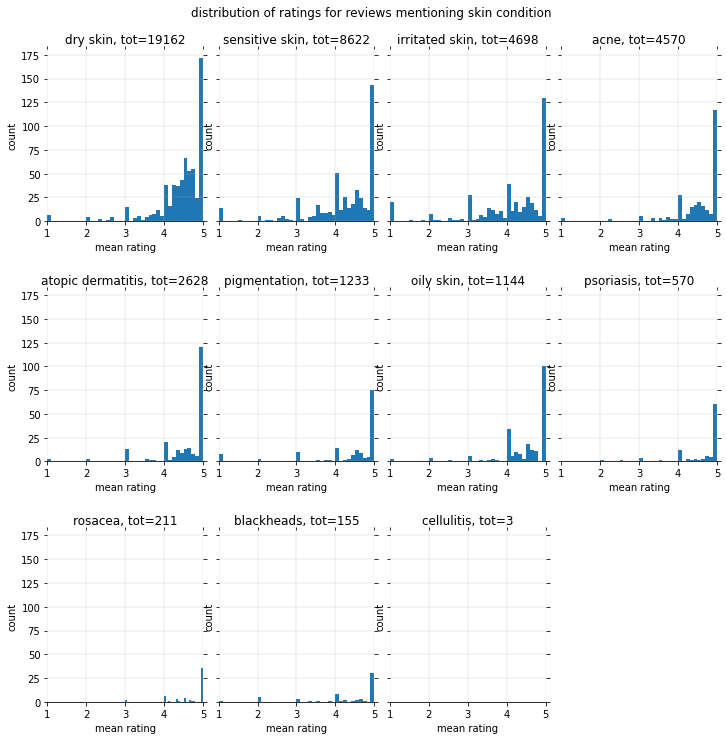

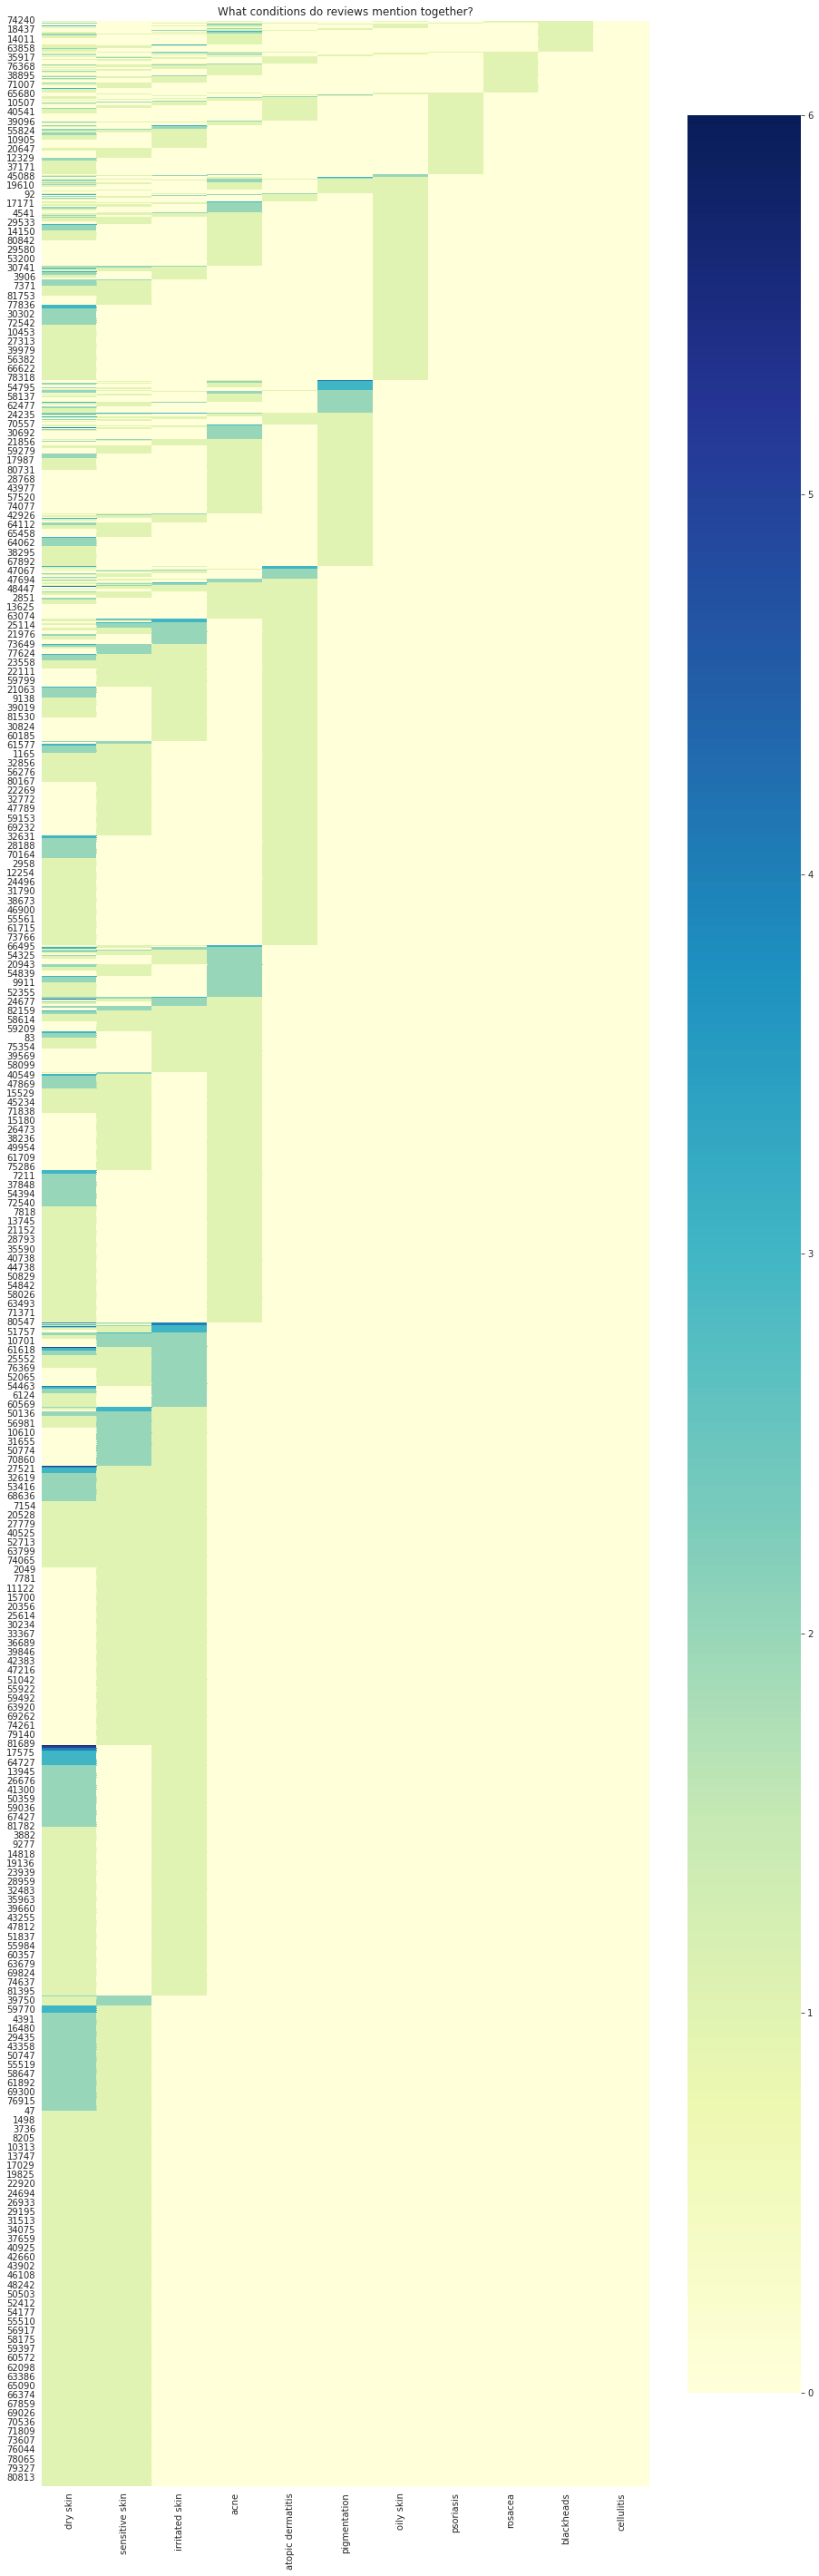

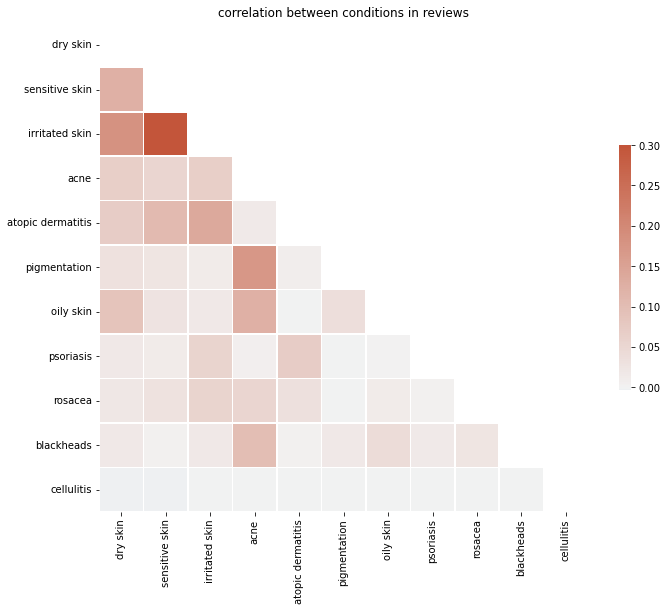

analyzing condition: dry skin, rating [1]
number of sentences in this section : 804
preforming sentiment analysis
********** POSITIVE , probability > than 0.9 **********
Number of reviews like this: 32 

********** POSITIVE , probability < than 0.9 **********
Number of reviews like this: 10 

********** NEGATIVE , probability < than 0.9 **********
Number of reviews like this: 26 

********** NEGATIVE , probability > than 0.9 **********
Number of reviews like this: 736 

irritated my skin. i wanted to give this soap a try since i love the dhc cleansing oil. this soap irritated my skin causing redness and burning. it also left my face feeling dry and tight. i will be returning this for a refund. 

disappointed with this overall disappointed with this overall. the dispenser doesn't work well, and it's a mess to mix the concentrate with water. it doesn't foam well. it doesn't dispense well. it leaves my skin feeling more dry than the dove instant foaming shower foam. i won't buy more of th

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.19 sec

Cluster 1, #43 Elements 
	 left my skin dry
	 my skin is left dry as if using a bar of soap
	 dry made skin dry
	 ...
	 left my skin rough and dry
	 makes skin feel dry
	 made skin feel dry and itchy

Cluster 2, #42 Elements 
	 i thought this would be a gentle face soap but it broke my skin out immediately and made it really dry
	 cleans well but if you have sensitive or dry skin this is not the soap for you
	 i don't understand why a soap made for dry skin would include this ingredients
	 ...
	  skin peeling i don’t have sensitive skin, but this soap made my skin dry and peel
	 great moisturizing soap, but irritated my skin unfortunately, the soap triggered an allergic reaction
	 can’t use this soap actually made my skin dry

Cluster 3, #26 Elements 
	 it also was not moisturizing at all
	 threw it out it might be moisturizing, don’t know
	 doesn't moisturize
	 ...
	 does not moisturize
	 it is moisturizing
	 this is the opposite of moi

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

saving result embeddings
queries_embeding_string: /content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/queries_embeddingsparaphrase-albert-small-v2dry skin1.csv
loading encodings from file
['/content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/queries_embeddingsparaphrase-albert-small-v2dry skin1.csv']
answer_pool_embedding_string: /content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/answer_pool_embeddingsparaphrase-albert-small-v2dry skin2345.csv
loading encodings from file
['/content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/answer_pool_embeddingsparaphrase-albert-small-v2dry skin2345.csv']
manual_sentences_embedding_string: /content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/manual_sentences_embeddingsparaphrase-albert-small-v2dry skinratings_irrelevant.csv
loading encodings from file
['/content/drive/MyDrive/Me_Now_nlp_project/analysis/embeddings/manual_sentences_embeddingsparaphrase-albert-small-v2dry skinratings_irrelevant.csv']
typ

In [45]:
#%%script false --no-raise-error
# main call: 
if __name__=='__main__':
  main_args={
      # 'currently_analyzing':currently_analyzing,
      # 'analysis_path': analysis_path,
      # 'keywords_file_name': keywords_file_name,        
      # #'condition_to_analyze': 'dry skin',
      # 'bad_rating_list' : [1],
      # 'pool_rating_list': [2,3,4,5],
      # 'TH' : 0.9, 
      # ##'s_transformer_string' : 'paraphrase-albert-small-v2',
      # #'s_transformer_string' : 'all-MiniLM-L12-v2',
      # 'pipline_task': "sentiment-analysis",
      # 'tokenizer_kwargs' : {'padding':True,'truncation':True,'max_length':512},
  }
  condition_to_analyze = 'dry skin'
  s_transformer_string= 'paraphrase-albert-small-v2'
  #s_transformer_string = 'all-MiniLM-L12-v2'
  bad_rating_list = [1]
  pool_rating_list = [2,3,4,5]
  #TH = 0.9
  sa_TH= 0.9 # sentiment analysis TH
  ss_TH=0.85 # semantic search TH
  cluster_TH=0.75
  pipline_task = "sentiment-analysis"
  tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
  
  # running main
  corpus_of_queries, queries_embeddings, answer_pool, answer_pool_embeddings, center_of_clusters, center_of_clusters_embeddings = classic_NLP_main(**main_args)
  print ('all done.')